## Full data prediction (for *Data-driven prediction of battery cycle life before capacity degradation*)
### Feature-generated version

##### Since we have checked that the self-organizing map (SOM) does not work well with small number of samples, the goal now is to turn to using features to predict. We will try different models to predict, including linear and nonlinear models.

Import all packages:

In [1]:
%matplotlib inline

import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
from sklearn.utils import shuffle
from scipy.stats import skew, kurtosis
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
import sys, os

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

*Note: If section 1 is already runned before, there is no need to run it again. You can skip to section 2.*

### 1. Load and save the data


We load and select the raw data and save as a pickle file for easy access later.
#
There are 140 raw data in total in .json format. We only save the data inside 'cycles_interpolated' with 'cycle_index'<=100 for each battery cell to use for feature-generated prediction. We remove the same data as in the self-organizing map notebook (the cells that are with the empty data or terminated before the discharge capacity reaches 80% of the nominal value). The cycle life derived in the self-organizing map notebook for each battery cell is added to the saved dataset here.

In [2]:
files = glob.glob("FastCharge/*.json")
full_data = {}
invalid = [6, 43, 59, 60, 77, 88, 89, 99, 100, 101, 102, 125, 126] # the same invalid data as in the self-organizing map notebook
cycle_life = pd.read_pickle("full_data_filtered_som.pkl")['cycle_life'] # the same cycle life derived in the self-organizing map notebook
i=0

for index, file in enumerate(tqdm(files, desc="Processing files")):
    if index not in invalid: # exclude invalid data
        with open(file, "r") as f:
            data = pd.read_json(f)['cycles_interpolated'] # obtain the data inside 'cycles_interpolated'
            condition_array = np.array(data['cycle_index']) > 100
            change_indices = np.where(np.logical_and(~condition_array[:-1], condition_array[1:])) # check at which point the 'cycle_index' exceeds 100
            full_data[index] = {'Remaining Useful Life':cycle_life[i], 'timeseries data':data.apply(lambda x: x[:change_indices[0][0]+1] if isinstance(x, list) else x)} # save the data with 'cycle_index'<=100
            i = i + 1

Processing files: 100%|██████████| 140/140 [02:26<00:00,  1.05s/it]


In [3]:
# Check the data
full_data

{0: {'Remaining Useful Life': 461,
  'timeseries data': cycle_index                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
  discharge_capacity             [1.176888566896429, 0.9488411090520571, 0.7207...
  charge_capacity                [0.685290364342907, 0.46119085672688004, 0.237...
  discharge_energy                                                             NaN
  charge_energy                                                                NaN
  dc_internal_resistance                                                       NaN
  temperature_maximum                                                          NaN
  temperature_average                                                          NaN
  temperature_minimum                                                          NaN
  date_time_iso                                                                NaN
  energy_efficiency                                                            NaN
  charge_throughput              

In [4]:
# Save the data
with open('full_data_features.pkl', 'wb') as f:
    pickle.dump(full_data, f)

### 2. Featurizing the data

In [5]:
# Load the saved data
full_data = pd.read_pickle("full_data_features.pkl")

For each cell, we calculate a number of "features" of interest from the timeseries data, and use them as input to linear and nonlinear models to predict lifetime. "Features" are defined in reference to *Data-driven prediction of battery cycle life before capacity degradation*.

In [6]:
# Let's define functions that calculate each of those features

def extract_discharge_capacity(timeseries, cycle):
    # Extract the maximum discharge capacity for a given cycle
    # Discharge capacity is decreased in a single cycle, so we just need to take the first value in a cycle
    discharge_capacity = np.array(timeseries['voltage'])[np.array(timeseries["cycle_index"]) == cycle][0]

    return discharge_capacity
    
def linear_fit_discharge_capacity(timeseries, cycle_a, cycle_b):
    # Given a start cycle and an end cycle, calculate the line-of-best-fit in discharge capacity
    discharge_capacities = []
    cycle_indices = []
    for cycle in range(cycle_a, cycle_b):
        # Get all discharge capacities across the range of interest
        discharge_capacity = extract_discharge_capacity(timeseries, cycle)
        discharge_capacities.append(discharge_capacity)
        cycle_indices.append(cycle)
        
    # Do the linear regression using numpy, and return the slope and intercept    
    slope, intercept = np.polyfit(cycle_indices, discharge_capacities, 1)
    
    return slope, intercept

def min_internal_resistance(timeseries):
    # Return the minimum internal resistance across the cell's lifetime
    
    min_resistance = min(timeseries["internal_resistance"])
    return min_resistance

def delta_resistance(timeseries, cycle_a, cycle_b):
    # Given two cycles, calculate the difference in internal resistance between the two
    # Internal resistance is very stable within a single cycle, take the median to avoid noise
    cycle_a_resistance = np.median(np.array(timeseries["internal_resistance"])[np.array(timeseries["cycle_index"]) == cycle_a])
    cycle_b_resistance = np.median(np.array(timeseries["internal_resistance"])[np.array(timeseries["cycle_index"]) == cycle_b])

    delta_resistance = cycle_a_resistance - cycle_b_resistance
    return delta_resistance

def delta_q_mul(timeseries, cycle_a, cycle_b):
    # Calculate "delta Q", the difference between the discharge capacity curves for two cycles
    # Reduce it to a single number by taking the minimum, variance, skewness, kurtosis
    
    # Get the discharge capacity curve at cycle_one, reset index to start series from 0
    cycle_a_delta_q = np.array(timeseries["discharge_capacity"])[np.array(timeseries["cycle_index"]) == cycle_a]
    cycle_b_delta_q = np.array(timeseries["discharge_capacity"])[np.array(timeseries["cycle_index"]) == cycle_b]
    
    delta_q = cycle_a_delta_q - cycle_b_delta_q
    delta_q_min = delta_q.min()
    delta_q_var = delta_q.var()
    delta_q_skew = skew(delta_q, axis=0, bias=True)
    delta_q_kur = kurtosis(delta_q, axis=0, bias=True)
    
    return delta_q_min, delta_q_var, delta_q_skew, delta_q_kur

In [7]:
# Define a convenience function that will calculate all the features and return them in a list, which is ready to be used as ML input
# The 10 Features are: [discharge capacity at cycle 2, discharge capacity at cycle 100, discharge capacity slope, discharge capacity intercept, minimal resistance, Delta resistance from 2 to 100, and the minimum, variance, skewness, kurtosis of Delta q from 10 to 100]

def featurize(timeseries):
    features = []
    discharge_capacity_2 = extract_discharge_capacity(timeseries, 2)
    features.append(discharge_capacity_2)

    discharge_capacity_100 = extract_discharge_capacity(timeseries,100)
    features.append(discharge_capacity_100)

    discharge_capacity_slope, discharge_capacity_intercept = linear_fit_discharge_capacity(timeseries, 2, 100)
    features.append(discharge_capacity_slope)
    features.append(discharge_capacity_intercept)

    min_resistance = min_internal_resistance(timeseries)
    features.append(min_resistance)

    resistance_2_100 = delta_resistance(timeseries, 2, 100)
    features.append(resistance_2_100)

    min_delta_q, var_delta_q, skew_delta_q, kur_delta_q = delta_q_mul(timeseries, 10, 100)

    features.append(min_delta_q)
    features.append(var_delta_q)
    features.append(skew_delta_q)
    features.append(kur_delta_q)
    
    return features

In [8]:
# Input (different features) is defined as X, output (remaining useful life) is defined as y
X=[]
y=[]

for cell in tqdm(full_data.values()):
    # For each cell we get the timeseries data
    timeseries = cell["timeseries data"]
    # Calculate all the features to use as input
    features = featurize(timeseries)
    X.append(features)
    # Train Target is log remaining useful life
    y.append(np.log10(cell["Remaining Useful Life"]))

print(f'{len(X)} points loaded in total, each with {len(X[0])} features')
print('Example point:', X[0])

100%|██████████| 127/127 [01:16<00:00,  1.67it/s]

127 points loaded in total, each with 10 features
Example point: [2.799999952316284, 2.799999952316284, -6.200009559926888e-18, 2.799999952316285, 0.016434930264949, 0.001034868881106002, -0.0007957030797430004, 0.0009025100352306113, -0.07604944981443662, -1.946976908172982]


### 3. Divide the data into the train set and the test set
We want 80% of the data to be the train set and the rest (20%) to be the test set.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 4. Build and test different models

#### (4.1) Linear model

In [10]:
model = LinearRegression()

# Now we use scikit learn to train a simple linear model
model.fit(X_train, y_train)

# And make predictions on the test set
y_pred = model.predict(X_test)
# Recall we trained on log(remaining useful life), so we take exponential to get a remaining useful life prediction
y_pred = [10**i for i in y_pred]
y_test = [10**i for i in y_test]
# Let's examine the mean absolute error and mean absolute percentage error
mae1 = mean_absolute_error(y_test, y_pred)
mape1 = mean_absolute_percentage_error(y_test, y_pred)

print('MAE:', mae1)
print('MAPE:', mape1)

MAE: 157.0975098255026
MAPE: 0.2843605146381297


Visualize the predicting result:

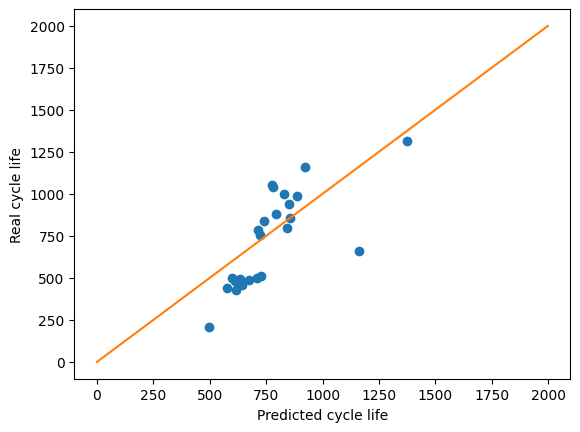

In [11]:
plt.figure()
plt.scatter(y_pred, y_test)
plt.plot(range(0,2000),range(0,2000), color='C1')
plt.xlabel('Predicted cycle life')
plt.ylabel('Real cycle life')
plt.show()

#### (4.2) Decision tree model

In [12]:
model = DecisionTreeRegressor(random_state=0)

#Now we use scikit learn to train a decision tree model using k-fold cross validation and grid search to find the best model with hyperparameters tunned

#First we define that we use 5 folds to conduct cross validation
skf = KFold(n_splits=5, random_state=10, shuffle=True)
#Then use grid search to tune for the best hyper parameters
model_search = GridSearchCV(estimator=model, param_grid={'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_depth':np.arange(2,10)}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
#Fit the model
model_search.fit(X_train, y_train)
#Get the best model
model = model_search.best_estimator_

#And make predictions on the test set
y_pred = model.predict(X_test)
#Recall we trained on log(remaining useful life), so we take exponential to get a remaining useful life prediction
y_pred = [10**i for i in y_pred]
#Let's examine the mean absolute error and mean absolute percentage error
mae2 = mean_absolute_error(y_test, y_pred)
mape2 = mean_absolute_percentage_error(y_test, y_pred)

print('MAE:', mae2)
print('MAPE:', mape2)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-0.066, test=-0.060) neg_mean_squared_error: (train=-0.007, test=-0.005) r2: (train=0.809, test=0.754) total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-0.065, test=-0.083) neg_mean_squared_error: (train=-0.007, test=-0.014) r2: (train=0.794, test=0.600) total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-0.062, test=-0.070) neg_mean_squared_error: (train=-0.006, test=-0.006) r2: (train=0.816, test=0.747) total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-0.061, test=-0.081) neg_mean_squared_error: (train=-0.006, test=-0.010) r2: (train=0.832, test=0.664) total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-0.061, test=-0.083) neg_mean_squar

Visualize the predicting result:

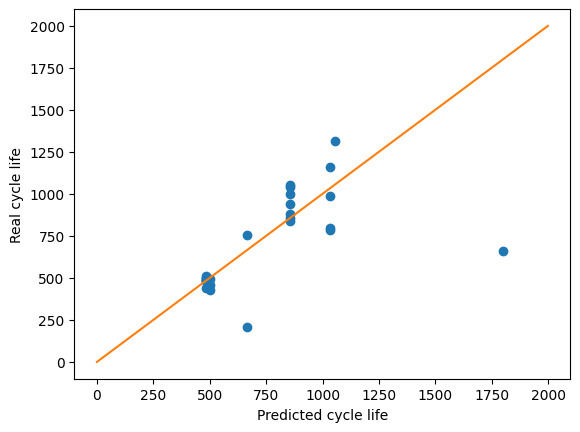

In [13]:
plt.figure()
plt.scatter(y_pred, y_test)
plt.plot(range(0,2000),range(0,2000), color='C1')
plt.xlabel('Predicted cycle life')
plt.ylabel('Real cycle life')
plt.show()

#### (4.3) Extremely randomized tree model (from *Feature engineering for machine learning enabled early prediction of battery lifetime*)
Extra-trees differ from classic decision trees in the way they are built. When looking for the best split to separate the samples of a node into two groups, random splits are drawn for each of the *max_features* randomly selected features and the best split among those is chosen. When *max_features* is set 1, this amounts to building a totally random decision tree.

In [14]:
model = ExtraTreeRegressor(random_state=0)

#Now we use scikit learn to train an extremely randomized tree model using k-fold cross validation and grid search to find the best model with hyperparameters tunned
model_search = GridSearchCV(estimator=model, param_grid={'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_depth':np.arange(2,10)}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
model_search.fit(X_train, y_train)
model = model_search.best_estimator_

#And make predictions on the test set
y_pred = model.predict(X_test)
#Recall we trained on log(remaining useful life), so we take exponential to get a remaining useful life prediction
y_pred = [10**i for i in y_pred]
#Let's examine the mean absolute error and mean absolute percentage error
mae3 = mean_absolute_error(y_test, y_pred)
mape3 = mean_absolute_percentage_error(y_test, y_pred)

print('MAE:', mae3)
print('MAPE:', mape3)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-0.092, test=-0.071) neg_mean_squared_error: (train=-0.011, test=-0.007) r2: (train=0.674, test=0.661) total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-0.089, test=-0.095) neg_mean_squared_error: (train=-0.011, test=-0.012) r2: (train=0.664, test=0.673) total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-0.089, test=-0.086) neg_mean_squared_error: (train=-0.011, test=-0.009) r2: (train=0.679, test=0.644) total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-0.084, test=-0.102) neg_mean_squared_error: (train=-0.010, test=-0.015) r2: (train=0.702, test=0.527) total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-0.082, test=-0.106) neg_mean_squar

Visualize the predicting result:

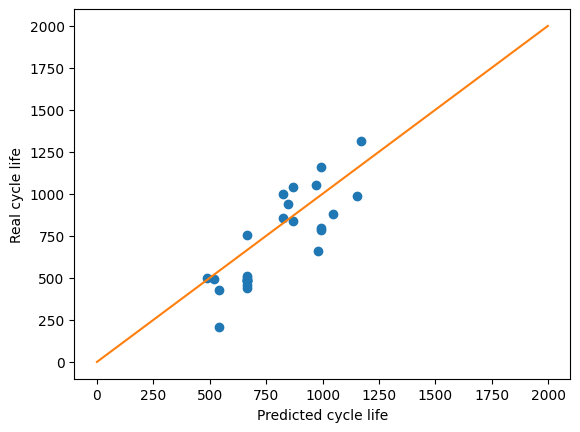

In [15]:
plt.figure()
plt.scatter(y_pred, y_test)
plt.plot(range(0,2000),range(0,2000), color='C1')
plt.xlabel('Predicted cycle life')
plt.ylabel('Real cycle life')
plt.show()

#### (4.4) Random forest model
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [16]:
model = RandomForestRegressor(random_state=0)

#Now we use scikit learn to train a random forest model using k-fold cross validation and grid search to find the best model with hyperparameters tunned
model_search = GridSearchCV(estimator=model, param_grid={'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_depth':np.arange(2,10)}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
model_search.fit(X_train, y_train)
model = model_search.best_estimator_

#And make predictions on the test set
y_pred = model.predict(X_test)
#Recall we trained on log(remaining useful life), so we take exponential to get a remaining useful life prediction
y_pred = [10**i for i in y_pred]
#Let's examine the mean absolute error and mean absolute percentage error
mae4 = mean_absolute_error(y_test, y_pred)
mape4 = mean_absolute_percentage_error(y_test, y_pred)

print('MAE:', mae4)
print('MAPE:', mape4)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-0.060, test=-0.052) neg_mean_squared_error: (train=-0.006, test=-0.004) r2: (train=0.834, test=0.809) total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-0.056, test=-0.055) neg_mean_squared_error: (train=-0.005, test=-0.006) r2: (train=0.842, test=0.841) total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-0.054, test=-0.065) neg_mean_squared_error: (train=-0.005, test=-0.005) r2: (train=0.851, test=0.785) total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-0.055, test=-0.073) neg_mean_squared_error: (train=-0.005, test=-0.009) r2: (train=0.854, test=0.714) total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=2; neg_mean_absolute_error: (train=-0.051, test=-0.083) neg_mean_squar

Visualize the predicting result:

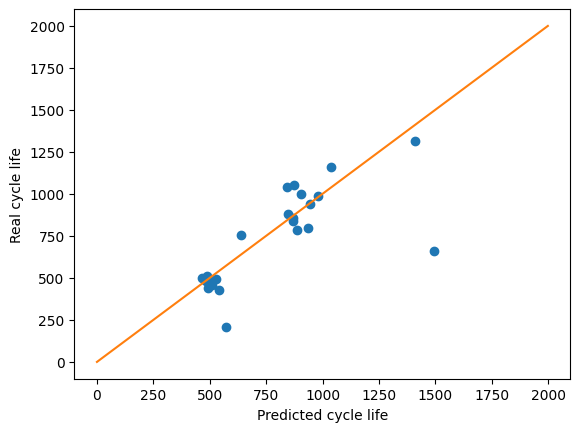

In [17]:
plt.figure()
plt.scatter(y_pred, y_test)
plt.plot(range(0,2000),range(0,2000), color='C1')
plt.xlabel('Predicted cycle life')
plt.ylabel('Real cycle life')
plt.show()

#### (4.5) k-nearest neighbors model
The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.

In [18]:
model = KNeighborsRegressor()

#Now we use scikit learn to train a k-nearest neighbors model using k-fold cross validation and grid search to find the best model with hyperparameters tunned
model_search = GridSearchCV(estimator=model, param_grid={'n_neighbors':np.arange(2,10), 'weights':['uniform', 'distance'], 'algorithm':['ball_tree', 'kd_tree', 'brute']}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
model_search.fit(X_train, y_train)
model = model_search.best_estimator_

#And make predictions on the test set
y_pred = model.predict(X_test)
#Recall we trained on log(remaining useful life), so we take exponential to get a remaining useful life prediction
y_pred = [10**i for i in y_pred]
#Let's examine the mean absolute error and mean absolute percentage error
mae5 = mean_absolute_error(y_test, y_pred)
mape5 = mean_absolute_percentage_error(y_test, y_pred)

print('MAE:', mae5)
print('MAPE:', mape5)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END algorithm=ball_tree, n_neighbors=2, weights=uniform; neg_mean_absolute_error: (train=-0.075, test=-0.126) neg_mean_squared_error: (train=-0.009, test=-0.020) r2: (train=0.732, test=0.074) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, n_neighbors=2, weights=uniform; neg_mean_absolute_error: (train=-0.070, test=-0.091) neg_mean_squared_error: (train=-0.008, test=-0.017) r2: (train=0.733, test=0.525) total time=   0.0s
[CV 3/5] END algorithm=ball_tree, n_neighbors=2, weights=uniform; neg_mean_absolute_error: (train=-0.066, test=-0.092) neg_mean_squared_error: (train=-0.008, test=-0.013) r2: (train=0.759, test=0.480) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, n_neighbors=2, weights=uniform; neg_mean_absolute_error: (train=-0.072, test=-0.117) neg_mean_squared_error: (train=-0.009, test=-0.022) r2: (train=0.722, test=0.296) total time=   0.0s
[CV 5/5] END algorithm=ball_tree, n_neighbors=2, weights=u

Visualize the predicting result:

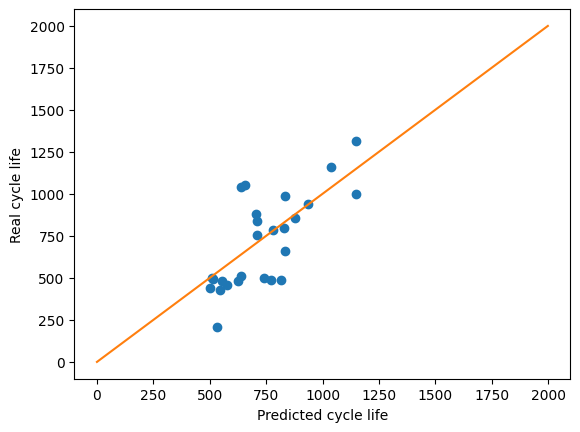

In [19]:
plt.figure()
plt.scatter(y_pred, y_test)
plt.plot(range(0,2000),range(0,2000), color='C1')
plt.xlabel('Predicted cycle life')
plt.ylabel('Real cycle life')
plt.show()

#### (4.6) Summary
Compare the mean absolute percent error of each regression method. Each method is repeated 10 times by random train and test data, and average mean absolute percent errors are taken in order to make the results more general.

100%|██████████| 10/10 [02:40<00:00, 16.02s/it]


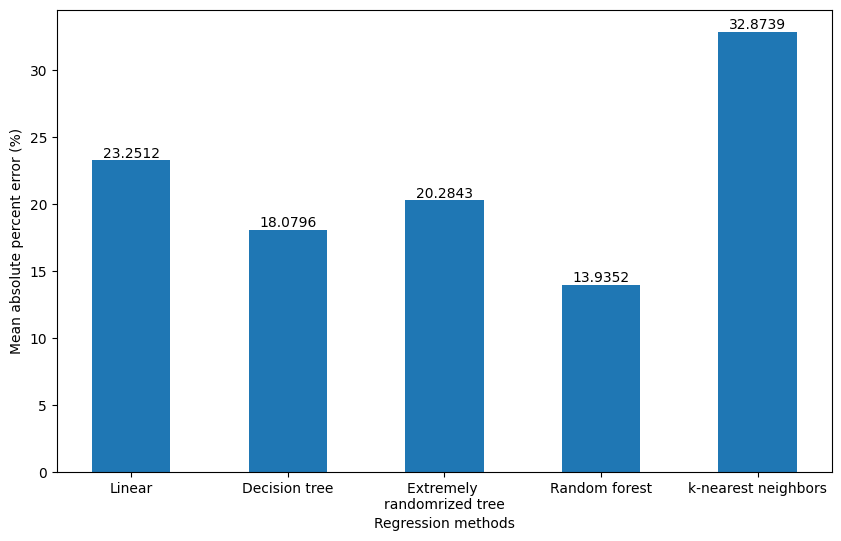

In [20]:
mape_t=np.zeros((10,5))
original_stdout = sys.stdout

for i in tqdm(range(10)):
    sys.stdout = open(os.devnull, 'w')
    
    mape=[]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = [10**i for i in y_pred]
    y_test = [10**i for i in y_test]
    mape.append(mean_absolute_percentage_error(y_test, y_pred))

    model = DecisionTreeRegressor()
    skf = KFold(n_splits=5, random_state=10, shuffle=True)
    model_search = GridSearchCV(estimator=model, param_grid={'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_depth':np.arange(2,10)}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
    model_search.fit(X_train, y_train)
    model = model_search.best_estimator_
    y_pred = model.predict(X_test)
    y_pred = [10**i for i in y_pred]
    mape.append(mean_absolute_percentage_error(y_test, y_pred))

    model = ExtraTreeRegressor()
    model_search = GridSearchCV(estimator=model, param_grid={'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_depth':np.arange(2,10)}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
    model_search.fit(X_train, y_train)
    model = model_search.best_estimator_
    y_pred = model.predict(X_test)
    y_pred = [10**i for i in y_pred]
    mape.append(mean_absolute_percentage_error(y_test, y_pred))

    model = RandomForestRegressor()
    model_search = GridSearchCV(estimator=model, param_grid={'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_depth':np.arange(2,10)}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
    model_search.fit(X_train, y_train)
    model = model_search.best_estimator_
    y_pred = model.predict(X_test)
    y_pred = [10**i for i in y_pred]
    mape.append(mean_absolute_percentage_error(y_test, y_pred))

    model = KNeighborsRegressor()
    model_search = GridSearchCV(estimator=model, param_grid={'n_neighbors':np.arange(2,10), 'weights':['uniform', 'distance'], 'algorithm':['ball_tree', 'kd_tree', 'brute']}, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=skf, refit='neg_mean_absolute_error', verbose=3, return_train_score=True)
    model_search.fit(X_train, y_train)
    model = model_search.best_estimator_
    y_pred = model.predict(X_test)
    y_pred = [10**i for i in y_pred]
    mape.append(mean_absolute_percentage_error(y_test, y_pred))

    mape_t[i]=mape
    sys.stdout = original_stdout

plt.figure(figsize = (10, 6))
bars=plt.bar(['Linear','Decision tree','Extremely \nrandomrized tree','Random forest','k-nearest neighbors'],np.mean(mape_t,axis=0)*100,width = 0.5)
plt.xlabel("Regression methods")
plt.ylabel("Mean absolute percent error (%)")
plt.bar_label(bars)
plt.show()

We can see that the random forest regressor yields the best performance, but all methods have much better prediction than the self-organizing map method, proving that **feature-generated predictions are better for small number of samples**. 